<a href="https://colab.research.google.com/github/praveenkumarbalakrishnan/tasks/blob/main/SIG731_Data_Wrangling_Task8HD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Title:** Task 8HD: SIG731-Data Wrangling

**Name:** Praveenkumar Balakrishnan

**Student Number:** 223029369

**Email Address:** s223029369@deakin.edu.au


# Import statements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [170]:
import argparse
import re
import os
import time
import xml.etree.cElementTree as cetree

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Tasks

Selected Movies & TV dataset for this analysis

**Task 1**

Convert all the data tables (Badges, Comments, PostHistory, PostLinks, Posts, Tags, Users, Votes)
from XML to CSV, using custom code that you write yourself. Ideally, you should write a Python
function that takes a single input file name (.xml) and output file name (.csv) and performs the
conversion of a single dataset.

**Task 2**

Load the CSV files as pandas data frames


Column names for 8 dataset based on the schema documentation

In [3]:
file_path = '/content/drive/MyDrive/Inputs/'

badges_cols = ['Id', 'UserId', 'Name', 'Date', 'Class', 'TagBased']
comments_cols = [
    'Id', 'PostId', 'Score', 'Text', 'CreationDate', 'UserDisplayName',
    'UserId', 'ContentLicense']
post_history_cols = [
    'Id', 'PostHistoryTypeId', 'PostId', 'RevisionGUID', 'CreationDate',
    'UserId', 'UserDisplayName', 'Comment', 'Text', 'ContentLicense']
post_links_cols = [
    'Id', 'CreationDate', 'PostId', 'RelatedPostId', 'LinkTypeId']
posts_cols = [
    'Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
    'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
    'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
    'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
    'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
    'ContentLicense']
tags_cols = [
    'Id', 'TagName', 'Count', 'ExcerptPostId', 'WikiPostId',
    'IsModeratorOnly', 'IsRequired']
users_cols = [
    'Id', 'Reputation', 'CreationDate', 'DisplayName', 'LastAccessDate',
    'WebsiteUrl', 'Location', 'AboutMe', 'Views', 'UpVotes', 'DownVotes',
    'ProfileImageUrl', 'AccountId']
votes_cols = [
    'Id', 'PostId', 'VoteTypeId', 'UserId',  'CreationDate', 'BountyAmount']

meta_dict = {
    'Badges': badges_cols, 'Comments': comments_cols,
    'PostHistory': post_history_cols, 'PostLinks': post_links_cols,
    'Posts': posts_cols, 'Tags': tags_cols, 'Users': users_cols,
    'Votes': votes_cols}

Parsed the xml elements, iterated in a loop and applied the regex functions to remove extra tags and other characters then load it in a csv file

In [4]:
def get_data(xml_file_name, cols_list):
    """
    This generator is to parse the xml data and yield as a row

    Parameters
    ----------
    file_name: str
      Input xml file name
    cols: list
      Column names of the input files
    
    Yield
    ------
    row: str
      Row from xml data
    """
    col_names = ''
    for col in cols_list:
      col_names = col_names + col + '|'
    col_names = col_names[:-1] + '\n'
    yield col_names

    for event, elem in cetree.iterparse(xml_file_name):
      row = ''
      if elem.tag == "row":
        for col in cols_list:
          if col in elem.attrib:
              val = elem.attrib[col].replace("|", " ").replace('\n', ' ')
              if col in ['Tags']:
                val = re.sub(r'<', '', val)
                val = re.sub(r'>', ' ', val)
              else:
                val = re.sub(r'<.?>', '', val)
                val = re.sub('[^A-Za-z0-9-:.]+', ' ', val)
                val = re.sub(' +', ' ', val)
              row = row + val.rstrip(' p') + '|'
          else:
              row = row + '|'
        row = row[:-1] + '\n'
        yield row
        elem.clear()

def convert_xml_to_csv(file_name, cols_list, path):
  """
  This function is to convert xml to csv and write as csv file
  and upper value

  Parameters
  ----------
  file_name: str
    Input filename without the extension like ".xml"
  cols: list
    Column names of the input files
  
  Return
  ------
  csv_filename: str
    Output csv filename
  """
  xml_file_name = os.path.join(path, file_name + '.xml')
  output_file_name = os.path.join(path, file_name + '.csv')

  data = get_data(xml_file_name, cols_list)
  with open(output_file_name, 'w') as f:
      for item in data:
          f.write(item)
  return output_file_name

Invoked xml conversion function and got the filename then used pandas read_csv to load the data into separate dataframes.

Note: Used dictionary to store the dataframe in the loop

In [5]:
data_dict = {}
for k, v in meta_dict.items():
  csv_file_name = convert_xml_to_csv(k, v, file_path)
  data_dict[k] = pd.read_csv(csv_file_name, delimiter='|')

Loaded as pandas dataframe for the further analysis

In [6]:
badges_df = data_dict['Badges']
comments_df = data_dict['Comments']
post_history_df = data_dict['PostHistory']
post_links_df = data_dict['PostLinks']
posts_df = data_dict['Posts']
tags_df = data_dict['Tags']
users_df = data_dict['Users']
votes_df = data_dict['Votes']

**Task 3**

Create at least five nontrivial data visualisations and/or tables, at least three of which are based
on the extraction of information from text (e.g., tags, keywords, locations, etc.).

Did Null handling and joining of the dataframes specicific to each analysis in the upcoming lines

**Wordcloud to view most used words in the Title column**

movie, character, scene, film, end, know..... are more frequently used and these are so relevant to the movies and tv posts

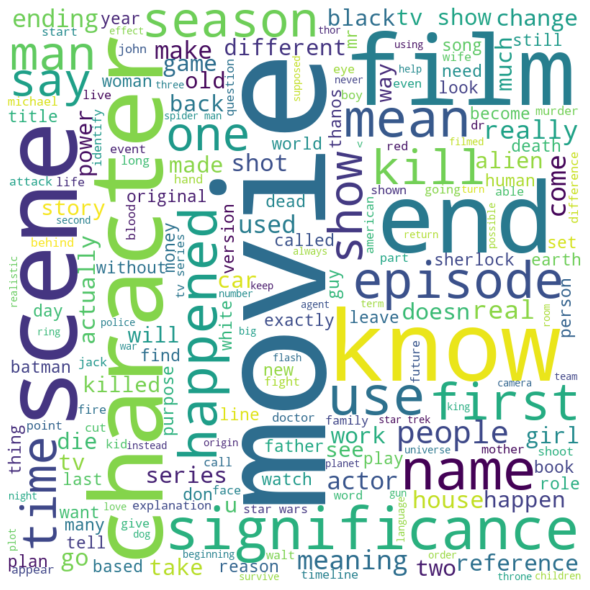

In [188]:
wc_df = posts_df.dropna(subset=['Title']) 
stopwords = set(list(STOPWORDS) + ['s', 'didn', 't'])
words = ' '.join(wc_df['Title'].astype(str)).lower()
wordcloud = WordCloud(
    stopwords=stopwords, min_font_size=10, background_color='white',
    width=800, height=800).generate(words)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Considered locations with user count more than 10 only and cleaned the locations to plot them. 

Assume user count less than 10 are part of the other locations

Cleaning the data to plot country wise users count

In [182]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['name'] = world['name'].str.upper()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,FIJI,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,TANZANIA,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. SAHARA,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,CANADA,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,UNITED STATES OF AMERICA,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,SERBIA,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,MONTENEGRO,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,KOSOVO,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,TRINIDAD AND TOBAGO,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [174]:
user_location_cnt_map = users_df['Location'].dropna().value_counts()[
    users_df['Location'].value_counts().dropna() > 10].to_dict()

In [179]:
cleaned_user_location_cnt_map = {}
for k, v in user_location_cnt_map.items():
  val = k.split(' ')[-1]
  if val in [
      'States', 'USA', 'California', 'CA', 'WA', 'IL', 'Texas', 'NY',
       'MA', 'TX', 'PA', 'GA', 'OR', 'York', 'Jersey', 'CO', 'Florida',
       'Utah', 'Michigan', 'MN', 'FL', 'Ohio', 'Massachusetts', 'Maryland',
       'Connecticut', 'Minnesota', 'OH', 'Carolina', 'DC', 'Francisco',
       'US', 'NC', 'MD', 'Virginia', 'Pennsylvania', 'Illinois', 'Arizona',
       'AZ', 'MO', 'Colorado', 'Oregon', 'Wisconsin', 'NYC', 'WI', 'Kansas',
       'Iowa', 'Indiana']:
    val = "United States of America"
  elif val in ['Kingdom', 'UK', 'England', 'London', 'Scotland']:
    val = "United Kingdom"
  elif val in [
      'Bangalore', 'Delhi', 'Pune', 'Chennai', 'Hyderabad', 'Ahmedabad',
      'Mumbai']:
    val = 'India'
  elif val in ['Zealand']:
    val = 'New Zealand'
  elif val in ['Lanka']:
    val = 'Sri Lanka'
  elif val in ['Emirates']:
    val = 'United Arab Emirates'
  elif val in ['Brasil']:
    val = 'Brazil'
  elif val in ['Paris']:
    val = 'France'
  elif val in ['Toronto']:
    val = 'Canada'
  elif val in ['Istanbul']:
    val = 'Turkey'
  elif val in ['Deutschland', 'Berlin']:
    val = 'Germany'
  elif val in ['xico']:
    val = 'Mexico'
  elif val in ['Republic', 'Prague']:
    val = 'Czechia'
  else:
    val = val
  if val.upper() in cleaned_user_location_cnt_map:
    v += cleaned_user_location_cnt_map[val.upper()]
  names = [col.lower() for col in world['name'].to_list()]
  if val.lower() in world['name'].str.lower().to_list():
    cleaned_user_location_cnt_map[val.upper()] = v

In [183]:
country_count_df = pd.DataFrame({
    'name': cleaned_user_location_cnt_map.keys(),
     'value': cleaned_user_location_cnt_map.values()})
world = world.merge(country_count_df, on=['name'], how='left')
world['value'] = world['value'].fillna(0)

No of users from America and India is high compared to other countries

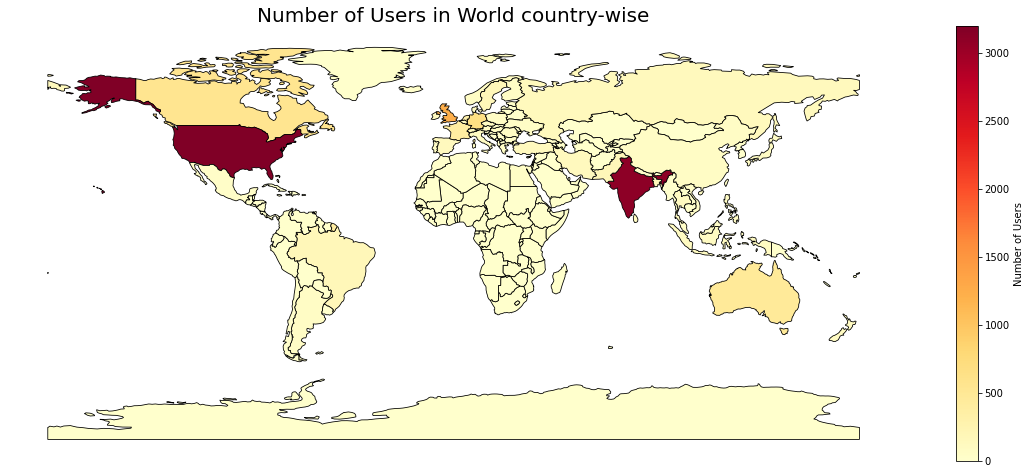

In [195]:
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off')
ax.set_title(
    'Number of Users in World country-wise',
     fontdict={'fontsize': '20', 'fontweight' : '10'})
# Plot the figure
world.plot(column='value',cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0',
           legend=True, markersize=[39.739192, -104.990337],
           legend_kwds={'label': "Number of Users"})
plt.show()

In [199]:
world.sort_values('value', ascending=False)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,value
4,3.282395e+08,North America,UNITED STATES OF AMERICA,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",3199.0
98,1.366418e+09,Asia,INDIA,IND,2868929,"POLYGON ((97.32711 28.26158, 97.40256 27.88254...",3106.0
143,6.683440e+07,Europe,UNITED KINGDOM,GBR,2829108,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",1234.0
121,8.313280e+07,Europe,GERMANY,DEU,3861123,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",665.0
3,3.758926e+07,North America,CANADA,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",558.0
...,...,...,...,...,...,...,...
67,5.380508e+06,Africa,CONGO,COG,12267,"POLYGON ((18.45307 3.50439, 18.39379 2.90044, ...",0.0
68,2.172579e+06,Africa,GABON,GAB,16874,"POLYGON ((11.27645 2.26105, 11.75167 2.32676, ...",0.0
69,1.355986e+06,Africa,EQ. GUINEA,GNQ,11026,"POLYGON ((9.64916 2.28387, 11.27645 2.26105, 1...",0.0
70,1.786103e+07,Africa,ZAMBIA,ZMB,23309,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...",0.0
